# Small networks and synapses

Prepared by Karla Montejo for the BU RISE Practicum in Computational Neuroscience, adapted from Paul Miller, 'An Introductory Course in Computational Neuroscience', MIT Press 2018 

In this lab we will make a small network (only 2 neurons!) using the LIF model we worked with earlier. We connect these neurons by synapses in such a way that the output of one neuron is the input to the other. The synapses will be identical, and inhibitory, allowing us to observe some intersting behavior in the activity of this network. 

If equations dont show properly, try rerunning this cell until they display correctly.

## Circuits, oscillations, and multistability

We have seen some examples of a single neuron’s response to an input, with the sea slug lab and the LIF lab. But a single neuron’s activity to an external input is not enough to cover the vast array of signals recorded from model organisms during behavior. Some organisms have seemingly complex behaviors that are carried out by relatively simple circuits. One example is rhythmic muscular contractions, which are usually involved in locomotion, digestion, chewing, and life sustaining activities such as sustaining a heartbeat or a breathing pattern. These activities can be modeled as oscillations (or rhythms) in small circuits of mathematical neurons.

The dynamics of circuits depends on their connectivity, the strengths of those connections, the activity time scales of the individual neurons, and other intrinsic properties. If neurons are connected to one another, the activity in response to an input may take on more complex patterns. Multistability refers to the property of having more than one stable pattern of activity in response to an input. If the activity patterns within circuits switch between states regularly, they are said to be oscillating. We will examine the conditions needed for networks to exhibit multistability. 

As mentioned above, the connectivity and synapses of a network determines the activation pattern of the neurons within it. If, for example, it is important that two muscles do not contract at the same time, cross-inhibition between the neurons wired to these muscles would be one possible solution. This refers to neurons that inhibit each other; as one fires, the other is suppressed. 

A simple model of an oscillation is where two neurons wired to one another fire by taking turns consistently over time. An example in nature would be the circuit for heartbeat control in medical leeches. The frequency (speed) of the oscillation, is controlled by the time it takes for a neuron to fire (rebound) after being inhibited. One interesting observation is that in model neurons, the rhythm tightly depends on the choice of parameters, whereas in nature many individual differences in these neurons are present and yet the rhythm is highly conserved.  

## Psychological motivation – bistable percepts in vision science

In psychology and vision science, visual illusions such as the Necker cube or Ruben’s Vase are used to probe stability of visual percepts. You may have come across these examples of perceptual bistability before, if not, give them a quick google. If an observer stares at the image, the perception is always one of two different forms, but never both forms at the same time. Bistability here refers to two stable percepts that are in competition. 

We will see how mutual inhibition between two neurons can produce bistability in a simple circuit with two mathematical neurons. We will be using leaky integrate and fire (LIF) neurons coupled together with inhibitory synapses. We will relate this to visual perceptual rivalry as explained above for visual percepts. 

## Part 1: Inhibitory synapses in a two-neuron circuit

We will now build our simplest possible circuit, only two LIF neurons! Each LIF neuron is simulated by a single equation for the membrane voltage, as a sum of all currents as we have seen before. We also use an additional equation to model the synapse current. Since we know synapses are active only when a neuron fires onto another neuron, we cannot use a constant value for the synaptic current like we can with the applied current.

We will set up the simulation to solve for the voltages of each cell (V1 and V2) with dynamic synaptic strength variables (s1 and s2) using the equations below. 

$$C \frac{dV_{1}}{dt} = \frac{E-V_{1}}{R} + G_{21}s_{2} (E_{21}^{rev} - V_{1}) + I_{1}^{app} + \sigma * \eta (t) $$

for neuron 1, where G21 refers to the conductance for the synapse from neuron two to neuron one, and s2 (the synaptic gating variable) refers to the strength of the synapse from neuron two. The last term in the equation is how we will inject noise into our system later. For now, we will set sigma equal to zero , meaining the noise term will be ignored, and eta(t) will be a call for python to generate a random number for us from a built in python method. Below: 

$$C \frac{dV_{2}}{dt} = \frac{E-V_{2}}{R} + G_{12}s_{1} (E_{12}^{rev} - V_{2}) + I_{2}^{app} + \sigma * \eta (t) $$

is the equation for neuron two. Notice that they are built identically but the output of one is the input of the other. 

If a spike occurs, we will reset the membrane potential to Vreset the same way we have before. 

Try to find similarities in this equation with the one we coded last lab in a single LIF neuron with no synapses. What is the additional current we are modeling with these equations? 

Answer: We are modeling an LIF neuron with two currents. One leak current, and one synaptic current as our model of a synapse. This synaptic current comes with its own reversal potential and conductance terms, same as any other current, but has an additional scalar called the synaptic gating variable. We also add an additional "noise" current which simulates the conditions of neurons in natural circuits which have some degree of randomness. 

We want the synaptic current to be dynamic, changing over time relative to when a spike occured, so we will introduce another differntial equation for the synaptic gating, which will make s1 and s2 initially very high after each neuron spikes, and then decay to a base value. 

For neuron one and two, the synaptic gating variables are defined as:

$$ \frac{ds_{1}}{dt} = \frac{-s_{1}}{\tau_{syn}} $$
and
$$ \frac{ds_{2}}{dt} = \frac{-s_{2}}{\tau_{syn}} $$

where after a spike occurs, s1 and s2 are reset to:

$$s_{1} = s_{1} + p_{R} D_{1}(1-s_{1})$$
$$s_{2} = s_{2} + p_{R} D_{2}(1-s_{2})$$

where the synaptic depression variables D1 and D2 are defined as: D1 = 1 and D2 = 1 for now. pR is the initial release probability of synaptic vesicles. pR is also set as pR = 1 at the moment. 

If we wanted to make the inhibitory currents exhibit short term synaptic depression we would change these to be dynamic variables by writing a differntial equation for them. But in this lab, we will use them as constants.


Lets set up our simulation parameters. These are given to be:

C = 1nF is the membrane capacitance, 
E = -70mV is the leak/reversal potential, 
Vth = -54mV is the voltage threshold, 
VR = -80mV is the reset potential, 
R = 10Mohm is the membrane resistance,
Iap1 = Iapp2 = 2nA.
sigma = 0 (for now, this makes the noise = 0)

Remember to properly balance units and make sure that our resulting units make sense in your simulation. (i.e. do not use mV somewhere and V elsewhere, or mA and nA similarly). Whatever you choose, keep it consistent! 

In [335]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import math

# set up the LIF neuron parameters 
# notice that the reset potential is different than reversal/resting potential in this lab. 
# simulation parameters
tmax = 5                      # total seconds of simulation time
dt = 0.1e-3                     # time-step in seconds

t_vector = np.arange(0,tmax,dt) # vector of time-points

# Parameters for the LIF neuron
E = -70e-3               # leak potential (also resting potential)
Vth = -54e-3               # threshold potential (to produce spike)
Vreset = -80e-3            # reset potential (post-spike)
Rm = 10e+6                 # membrane resistance
Cm = 1e-9                  # total membrane capacitance
Iap1 = 2e-9                # applied current
Iapp2 = 2e-9               # applied current
sigma = 0                  #n noise


We will wire together the two neurons with inhibitory connections with parameters defined as:

Erev 12 = Erev21 = -70mV  is the revresal potential for each of the synapses
G12 = G21 = 1uS  is the synaptic condunctance for both synapes
tausyn = 10ms is the msynaptic time constant


We can simulate this network for any amount of time using the forward Euler method we used last class, for example anywhere between 4 - 6 seconds is a good starting point. You want to use a short time step, around 0.1ms for this simulation. 

In [336]:
# set up your synaptic variables
# The synapses are modeled like additonal currents (or you can think of them as channels) 
# so they have their own max conductance and reversal potentials?
# E12 means the reversal potential of the synapse from neuron 1 to neuron 2, and vice versa.

Erev12 = -70e-3         # reversal potential for synapse 1 to 2 in milivolts
Erev21 = -70e-3         # reversal potential for synapse 1 to 2 in milivolts
G12 = 1e-6              # capacitance for synapse 1 to 2 in microfarads
G21 = 1e-6              # capacitance potential for synapse 1 to 2 in microfarads
tausyn = 10e-3          # msynaptic time constant
s1=1
s2=1

We will provide a constant baseline applied current of 2nA to the cells to keep them spiking, otherwise they would stay at rest. The spiking will also activate the synaptic currents. 

We will give an extra pulse of current to one cell at a time and see the response of the network when one cell is more active than the other. 

To do this, we can add an additional 3nA of current to one cell first for a short pulse of time, then wait until halfway through our simulation and inject the same pulse to the other cell. The two cells should not receievd these additional pulses at the same time. You can decide how long you want to make the pulse, and play around with that value.

In [337]:
# make an applied current (stimulation) vector using the base current we defined above, 
# give a constant 2nA to each neuron, adding an extra 3nA to each cell for a short pulse as written above.
ton = 1                         # time to begin applied current (onset)
toff = 2                        # time to end applied current (offset)
ind_on = round(ton/dt)          # time-point index of current onset sicne it isnt exact
ind_off = round(toff/dt)        # time-point index of current off sicne it isnt exact
     # initializing a vector for applied current at each time-point
Iapp = 2e-9                     # magnitude of applied current step in Amps
Ipulse =  3e-9      
I1 = Iapp*np.ones(len(t_vector)) # magnitude of pulse current step in Amps
I1[ind_on:ind_off] = Iapp+Ipulse 

ton = 3                         # time to begin applied current (onset)
toff = 4                        # time to end applied current (offset)     # initializing a vector for applied current at each time-point
ind_on = round(ton/dt)          # time-point index of current onset sicne it isnt exact
ind_off = round(toff/dt)        # time-point index of current off sicne it isnt exact
I2 = Iapp*np.ones(len(t_vector))
I2[ind_on:ind_off] = Iapp+Ipulse


Now we will pre-allocate the varibales we are solving for using the length of the time vector we created before. This is good coding practice when getting started. 

You will need to preallocate vectors for all variables you are solving for in the equations for the two cells (Hint: you will need four vectors, two variables for each cell you are simulating).

In [338]:
V1 = E*np.ones(len(t_vector))          # initialize the membrane potential vector
V2 = E*np.ones(len(t_vector))          # initialize the membrane potential vector
s1 = np.ones(len(t_vector))          # initialize the membrane potential vector
s2 = np.ones(len(t_vector))          # initialize the membrane potential vector

Now we will write our for loop to solve forward in time for each of our 4 variables of interst, updating our preallocated solution vectors with the result from each time step. 

Hint: a good way to write the equation for the solution for the forward time step is in the form

$$ X(n) = X(n-1) + \frac{dX}{dt} * \delta t $$

Because the LIF neuron does not produce a spike that looks like what we would expect from real neurons, in this lab we will "draw" the peak of the spike manually, just to make it easier to see the activity of the neuron over time. 

To the simualtion above, modifiy the statements in the for loop such that when a spike happens, the potential of the membrane at that time point will be set manually to 0mV before being reset to the reset potential. The real peak voltage of an action potential is positive, but this is only to help us visualize the spikes more realistically. 

The eta(t) term in the equations above refers to injected noise. This helps us mimic the noisy conditions of a real neuron. We will see later how impactful the noise is to the simulation. This noise will have to be randomly fluctuating, otherwise it is the same as adding to the constant input. We model this by choosing the amplitude of the noise (sigma) and sampling from normally distributed random noise (white noise).

To add noise, we call a built in python method random.randn()

Run the command a few times and see what the output is. 

In [339]:
print(random.randn())

-0.3562268960449757


In [340]:
# code your forward Euler loop here:
for loopiter, t in enumerate(t_vector):
    if loopiter == 0 or loopiter==49999:
        continue
    else:
        s1[loopiter]= s1[loopiter-1]+(-s1[loopiter-1]/tausyn)*dt
        s2[loopiter]= s2[loopiter-1]+(-s2[loopiter-1]/tausyn)*dt      
        dV1dt=((E-V1[loopiter-1])/Rm+G21*s2[loopiter]*(Erev21-V1[loopiter-1])+I1[loopiter-1]+sigma*random.randn())/Cm
        V1[loopiter]=V1[loopiter-1]+dV1dt*dt
        dV2dt=((E-V2[loopiter-1])/Rm+G12*s1[loopiter]*(Erev12-V2[loopiter-1])+I2[loopiter-1]+sigma*random.randn())/Cm
        V2[loopiter]=V2[loopiter-1]+dV2dt*dt   
# for timestep in time vector:
    # simulate the synaptic gating variables first,
    # then simulate the membrane voltage for each cell using the equations above
        if V1[loopiter]>=Vth:
                V1[loopiter] = Vreset
                V1[loopiter-1]=0
                s1=s1+(1-s1)
                s2=s2+(1-s2)
        if V2[loopiter]>=Vth:
                V2[loopiter] = Vreset
                V2[loopiter-1]=0
                s1=s1+(1-s1)
                s2=s2+(1-s2)
    # if theres a spike
        # manually draw a spike by setting Vm to 0mV for one step
        # then reset the membrane voltage and the synaptic gating variables according to above
        

Visualize your simulated voltage traces using matplotlib.pyplot which we have imported in the first line as plt.plot.

Plot the membrane voltage on the y-axis and the time step on the x-axis. 
Try plotting your applied current vectors as well, so you can observe how the timing of the applied currrent relates to the activity of the neuron. 

Plot the synaptic gating variable for a short time period in your simulation, what does it looks like? Does this make sense?

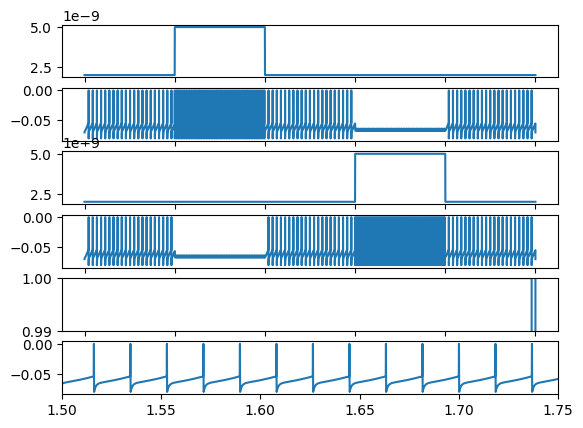

In [341]:
# modify the plotting lines below

fig, axs = plt.subplots(6)
axs[0].plot(t_vector,I1) # plot applied current to neuron1)
axs[4].axis(ymin=0.99,ymax=1)
axs[1].plot(t_vector,V1) # plot V1)
axs[2].plot(t_vector,I2) # plot applied current to neuron2)
axs[3].plot(t_vector,V2) # plot V2)
axs[4].plot(t_vector,s2) # plot synaptic gating variable for one neuron)
axs[5].axis(xmin=1.5,xmax=1.75)
axs[5].plot(t_vector,V1) # plot V1)

What do you observe in the activity of the neurons? What happens if you make the noise magnitude larger or smaller?

# Part 2: Adding noise to the system

Now we will set the noise value to be non-zero. Lets use sigma =  50pA per square root of our time step. (5*10^-11/sqrt(dt))

Rerun the simulation above with only the baseline applied current to each cell, removing the extra 3nA pulses we used above. 

Its better to copy and paste the peices of your code you need to rewrite below, rather than re-running the code above, that way you can directly compare the outputs by scolling through this lab. To be clear: you should create a whole new set of plots and compare them to comment on the effect noise has on this network. 

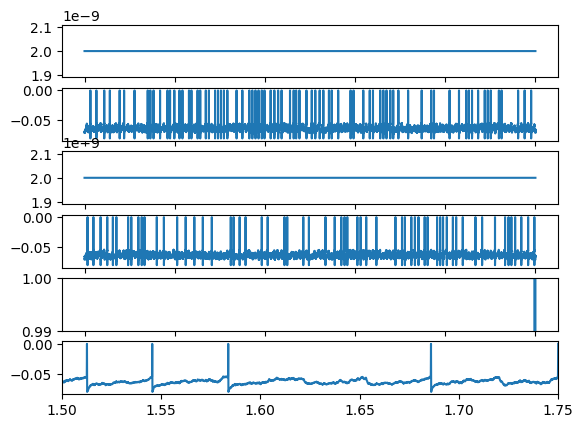

In [342]:
# insert new simualtion here with noise. 
# Plot your same variables again, including the synaptic gating variables. 
sigma = 50e-12/math.sqrt(dt)                 #n noise
fig, axs = plt.subplots(6)

Iapp = 2e-9                     # magnitude of applied current step in Amps
Ipulse =  0     
I1 = Iapp*np.ones(len(t_vector)) # magnitude of pulse current step in Amps
I1[ind_on:ind_off] = Iapp+Ipulse 

ton = 3                         # time to begin applied current (onset)
toff = 4                        # time to end applied current (offset)     # initializing a vector for applied current at each time-point
ind_on = round(ton/dt)          # time-point index of current onset sicne it isnt exact
ind_off = round(toff/dt)        # time-point index of current off sicne it isnt exact
I2 = Iapp*np.ones(len(t_vector))
I2[ind_on:ind_off] = Iapp+Ipulse

# code your forward Euler loop here:
for loopiter, t in enumerate(t_vector):
    if loopiter == 0 or loopiter==49999:
        continue
    else:
        s1[loopiter]= s1[loopiter-1]+(-s1[loopiter-1]/tausyn)*dt
        s2[loopiter]= s2[loopiter-1]+(-s2[loopiter-1]/tausyn)*dt      
        dV1dt=((E-V1[loopiter-1])/Rm+G21*s2[loopiter]*(Erev21-V1[loopiter-1])+I1[loopiter-1]+sigma*random.randn())/Cm
        V1[loopiter]=V1[loopiter-1]+dV1dt*dt
        dV2dt=((E-V2[loopiter-1])/Rm+G12*s1[loopiter]*(Erev12-V2[loopiter-1])+I2[loopiter-1]+sigma*random.randn())/Cm
        V2[loopiter]=V2[loopiter-1]+dV2dt*dt   
# for timestep in time vector:
    # simulate the synaptic gating variables first,
    # then simulate the membrane voltage for each cell using the equations above
        if V1[loopiter]>=Vth:
                V1[loopiter] = Vreset
                V1[loopiter-1]=0
                s1=s1+(1-s1)
                s2=s2+(1-s2)
        if V2[loopiter]>=Vth:
                V2[loopiter] = Vreset
                V2[loopiter-1]=0
                s1=s1+(1-s1)
                s2=s2+(1-s2)
    # if theres a spike
        # manually draw a spike by setting Vm to 0mV for one step
        # then reset the membrane voltage and the synaptic gating variables according to above

axs[0].plot(t_vector,I1) # plot applied current to neuron1)
axs[4].axis(ymin=0.99,ymax=1)
axs[1].plot(t_vector,V1) # plot V1)
axs[2].plot(t_vector,I2) # plot applied current to neuron2)
axs[3].plot(t_vector,V2) # plot V2)
axs[4].plot(t_vector,s2) # plot synaptic gating variable for one neuron)
axs[5].axis(xmin=1.5,xmax=1.75)
axs[5].plot(t_vector,V1) # plot V1)

What do you observe? how does this relate to the bistable visual percepts we discussed above.

## Challenge: Creating oscillations by adding short term synaptic depression

A central pattern generator is a circuit that can produce a pattern of activity that is consistent, or stable, and can be used to drive a series of muscles (as one example). The oscillations are a property of the network, only needing an input to start or sustain activity, but can otherwise run independently. Think of the way a worm moves, or how food is moved through the digestive system. These activities seem to happen automatically. We will see how to code this property into a network of neurons. 

As mentioned above, the connectivity and synapses of a network determines the activation pattern of the neurons within it. If it is important that two muscles do not contract at the same time, cross-inhibition between the neurons wired to these muscles would be one possible solution. This refers to neurons that inhibit each other; as one fires, the other is suppressed. 

Now we will introduce a process known as short term synaptic depression, or a temporary reduction in synaptic strength following each spike that recovers on a short time scale. You might come across this in your future computational neuroscience reading refered to as "dynamical synapses". 

We let D be the variable for synaptic depression (0<=D<=1) which represents the fraction of vesicles that can be released at any time from the pre-synaptic cell. This value represents an average fraction of vesicles, and recovers after the neuron is quiet for some time. This can be mathematically captured as a decaying exponential function we see in the equations for our neural system. 

We introduce a new set of equations to model this behavior:

$$ \frac{dD_{1}}{dt} = \frac{1-D_{1}}{\tau_{D}} $$

$$ \frac{dD_{2}}{dt} = \frac{1-D_{2}}{\tau_{D}} $$

tauD is the synaptic time constant, and determines how long the presynaptic neuron takes to recover. pR is the initial release probability of synaptic vesicles. 

After the cell spikes, D1 and D2 are reset to:

$$D_{1} = D_{1}(1-p_{R})$$
$$D_{2} = D_{2}(1-p_{R})$$

Rerun the simulation setting pR = 0.2 and tauD = 0.2s, what do you notice? Try and vary the amount of noise by changing sigma = 5pAs^-1/2. Play around with the noise values and comment on your findings. Recap your understanding by revisiting the behavioral circuits associated with the study of each of these mathematical circuits. 

At first, run with no noise, then try adding noise with different magnitudes. 


In [343]:
# you will need to introduce two more equations and reset conditions into the code you wrote above. 
# first have only the baseline applied current, then use the additional 3nA of current pulse to one neruon at a time